In [1]:
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# uint8 is not popular
y_train = y_train.astype('i4')
y_test = y_test.astype('i4')

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype('f4')
x_test = x_test[..., tf.newaxis].astype('f4')
n_train = x_train.shape[0]

In [3]:
model = tfk.Sequential([
    # tfk.layers.Reshape([28, 28, 1]),
    tfp.layers.Convolution2DReparameterization(filters=32, kernel_size=3, activation='relu'),
    tfk.layers.MaxPool2D(),
    tfk.layers.Flatten(),
    tfp.layers.DenseReparameterization(128, activation='relu'),
    tfp.layers.DenseReparameterization(10),
])
# model.build((1, 28, 28, 1))
# model.summary()

In [4]:
optimizer = tfk.optimizers.Adam()

train_loss = tfk.metrics.Mean(name='train_loss')
train_accuracy = tfk.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tfk.metrics.Mean(name='test_loss')
test_accuracy = tfk.metrics.SparseCategoricalAccuracy(name='test_accuracy')

BATCH_SIZE = 2**6
SAMPLE_SIZE = 64

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

In [5]:
# so many functions... just check they are the same
predictions = np.array([[-3.2, 0.4, 0.1], [-1.2, -9.1, 1.0]])
labels = np.array([1, 2])
print(- tfd.Categorical(logits=predictions).log_prob(labels))
print(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=predictions))

tf.Tensor([0.56992924 0.10512032], shape=(2,), dtype=float32)
tf.Tensor([0.56992925 0.1051203 ], shape=(2,), dtype=float64)


In [6]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # no explicit model weight posterior sampling here
        logits = model(images)
        nll = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        nll = tf.reduce_mean(nll)
        kldiv = sum(model.losses) / n_train
        loss = nll + kldiv

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, logits)

In [7]:
@tf.function
def test_step(images, labels, sampling=False):
    if sampling:
        # this doesn't work, tf.tile seems to shortcut sampling weights
        stack = tf.tile(images, (SAMPLE_SIZE, 1, 1, 1))
        sample_logits = tf.reshape(model(stack), (SAMPLE_SIZE, images.shape[0], 10))
        logits = tfp.stats.percentile(sample_logits, axis=0, q=0.5)
    else:
        logits = model(images)
    nll = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    nll = tf.reduce_mean(nll)
    
    test_loss(nll)
    test_accuracy(labels, logits)

In [8]:
@tf.function
def evaluate(images):
    return tf.nn.softmax(model(images))
#     stack = tf.tile(images, (SAMPLE_SIZE, 1, 1, 1))
#     sample_logits = tf.reshape(model(stack), (SAMPLE_SIZE, images.shape[0], 10))
#     logits = tfp.stats.percentile(sample_logits, axis=0, q=0.5)
#     return tf.nn.softmax(sample_logits)

In [9]:
EPOCHS = 20
history = defaultdict(list)

for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    if epoch == 10:
        optimizer.lr = 1e-4
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    history['train_loss'].append(float(train_loss.result()))
    history['train_accuracy'].append(float(train_accuracy.result()))
    history['test_loss'].append(float(test_loss.result()))
    history['test_accuracy'].append(float(test_accuracy.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    

  0%|          | 0/20 [00:00<?, ?epoch/s]WARNING: Logging before flag parsing goes to stderr.
W0930 21:52:41.151865 140735523619712 deprecation.py:323] From /Users/ncsmith/miniconda3/envs/tfd/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
100%|██████████| 20/20 [05:56<00:00, 17.83s/epoch]


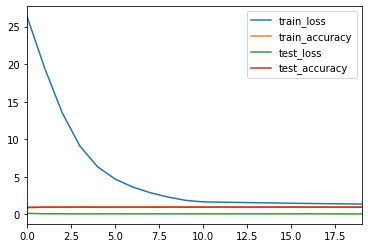

In [10]:
pd.DataFrame(history).plot()

In [11]:
n_test = x_test.shape[0]
class_max = np.empty(n_test)
CHUNK = 64
for chunk in tqdm.trange(n_test // CHUNK + 1):
    images = x_test[chunk*CHUNK:(chunk+1)*CHUNK]
    sample_probs = np.empty((SAMPLE_SIZE, images.shape[0], 10))
    for j in range(SAMPLE_SIZE):
        sample_probs[j] = evaluate(images)
    median_prob = np.median(sample_probs, axis=0)
    class_max[chunk*CHUNK:(chunk+1)*CHUNK] = np.max(median_prob, axis=1)

100%|██████████| 157/157 [00:53<00:00,  2.91it/s]


In [12]:
tough_entries, = np.where(class_max < 0.4)
print("Tough entries:", tough_entries)

for i in tough_entries:
    ex = x_test[i,...,0]
    lbl = y_test[i]
    # ex = np.random.rand(28, 28).astype('f4')

    fig, (ax_im, ax_p) = plt.subplots(ncols=2, figsize=(12, 5))

    ax_im.set_title("Entry %d, label: %d" % (i, lbl))
    ax_im.imshow(ex)

    sample_probs = np.empty((SAMPLE_SIZE, 10))
    for j in range(SAMPLE_SIZE):
        sample_probs[j] = evaluate(ex[None,...,None])
    
    ax_p.violinplot(sample_probs, positions=np.arange(10), showmedians=True)
    ax_p.set_ylabel('Probability')
    ax_p.set_xlabel('Class')
    
    fig.savefig('tough/entry_%d.png' % i)
    plt.close(fig)

Tough entries: [ 543  684  726 1326 1549 1709 1790 2018 2182 2266 2836 2921 2927 3030
 3559 3778 3853 3893 4007 4065 4256 4289 4601 5642 5734 5997 6625 6651
 8094 8408 9634 9768]


In [13]:
easy_entries, = np.where(class_max > 0.999)
print("Easy entries:", easy_entries)

for i in easy_entries[:5]:
    ex = x_test[i,...,0]
    lbl = y_test[i]
    # ex = np.random.rand(28, 28).astype('f4')

    fig, (ax_im, ax_p) = plt.subplots(ncols=2, figsize=(12, 5))

    ax_im.set_title("Entry %d, label: %d" % (i, lbl))
    ax_im.imshow(ex)

    sample_probs = np.empty((SAMPLE_SIZE, 10))
    for j in range(SAMPLE_SIZE):
        sample_probs[j] = evaluate(ex[None,...,None])
    
    ax_p.violinplot(sample_probs, positions=np.arange(10), showmedians=True)
    ax_p.set_ylabel('Probability')
    ax_p.set_xlabel('Class')
    
    fig.savefig('easy/entry_%d.png' % i)
    plt.close(fig)

Easy entries: [   0    1    2 ... 9997 9998 9999]
